[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/devdastl/EVA-8_Phase-1_Assignment-13/blob/main/Part2-VAE-implementation/pytorchLightning_VAE_cifar.ipynb)

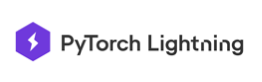

In [1]:
#%%capture
!pip install lightning-bolts==0.6.0.post1
!pip install lightning-lite==1.8.0
!pip install lightning-utilities==0.3.0
!pip install pytorch-lightning==1.8.0
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.0/330.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.4/136.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=

In [2]:
def correct_file(filename, line_number, new_line):
    with open(filename, 'r') as f:
        lines = f.readlines()

    lines[line_number-1] = new_line + '\n'

    with open(filename, 'w') as f:
        f.writelines(lines)

### Fixing some pytorch lightning issues.
PR are still in review .. ☹

In [3]:
correct_file('/usr/local/lib/python3.9/dist-packages/pl_bolts/datamodules/async_dataloader.py',9,"string_classes = str")

In [4]:
!pip list | grep lightning

lightning-bolts               0.6.0.post1
lightning-lite                1.8.0
lightning-utilities           0.3.0
pytorch-lightning             1.8.0


#### First 4 elements
The main 4 elements of a VAE are:
- encoder
- decoder
- mu
- sigma

mu, sigma are the parameters for the distributions in our formula.

Note: in our notation we say $q(z|x)$ where we assume $q$ to be a neural network. However, q is a neural network that DOES NOT GENERATE z. Instead it generates parameters FOR a distribution OVER z.

In [5]:
import torch
print(torch.__version__)

2.0.0+cu118


# Full Implementation
So, the full implementation is as follows.

In [24]:
from pl_bolts.datamodules import CIFAR10DataModule, MNISTDataModule
import torch
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=256, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        self.hot_emb = nn.Sequential(nn.Linear(10,10),
                nn.ReLU(),
                nn.Linear(10,256),
                nn.ReLU(),
                )
        self.mix =  nn.Sequential(nn.Linear(256,128),
                nn.ReLU(),
                nn.Linear(128,256),
                nn.ReLU(),
                )

 
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch

        #hot-encode and embed y
        y_hot = F.one_hot(y, num_classes=10).float()
        y_hot = self.hot_emb(y_hot)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

       
        z_hat  = z + y_hot
        z_hat = self.mix(z_hat)
        #z_hat = torch.cat([z, y_hot], dim=1)
        #z = self.down(z) # bringing size back to 256 from 266
      

        # decoded 
        x_hat = self.decoder(z_hat)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [7]:
!pip install --upgrade torch torchvision

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Downloading CIFAR10 data 

In [8]:
def get_loader():
    batch_size = 128*3
    use_cuda = True

    kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('.', train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('.', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4942,0.4851,0.4504), (0.2467,0.2429,0.2616))
                ])),
            batch_size=batch_size, shuffle=True, **kwargs)

    return train_loader

Now we train!

In [9]:

pl.seed_everything(1234)
vae = VAE()
train_loader = get_loader()
trainer = pl.Trainer(gpus=1, max_epochs=1)
trainer.fit(vae, train_loader)
trainer.save_checkpoint("vae_cifar.ckpt")

INFO:lightning_lite.utilities.seed:Global seed set to 1234
<ipython-input-6-b94f7508f891>:20: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/usr/local/lib/python3.9/dist-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/usr/local/lib/python3.9/dist-package

100%|██████████| 170498071/170498071 [00:03<00:00, 49147519.81it/s]


Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Plot images passing labels to the inferencing pipeline

In [28]:

mean, std = torch.tensor([0.4942,0.4851,0.4504]), torch.tensor([0.2467,0.2429,0.2616])
torch.manual_seed(20)
rand_img = (torch.rand(32,32,3) - mean)/std
#rand_img = torch.rand(32,32,3)
rand_img = rand_img.permute(2,0,1).unsqueeze(0)
rand_labl = torch.randint(0,9,(25,))
label = F.one_hot(rand_labl, num_classes=10).float()
print(rand_labl)

tensor([6, 8, 7, 0, 0, 7, 6, 8, 2, 0, 4, 0, 5, 3, 4, 5, 5, 0, 2, 0, 3, 1, 7, 4,
        7])


In [29]:
vae = VAE.load_from_checkpoint("vae_cifar.ckpt")
vae.device

/tmp/ipykernel_1453735/1055244507.py:20: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/tmp/ipykernel_1453735/1055244507.py:21: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(


device(type='cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 256]) torch.Size([25, 256])


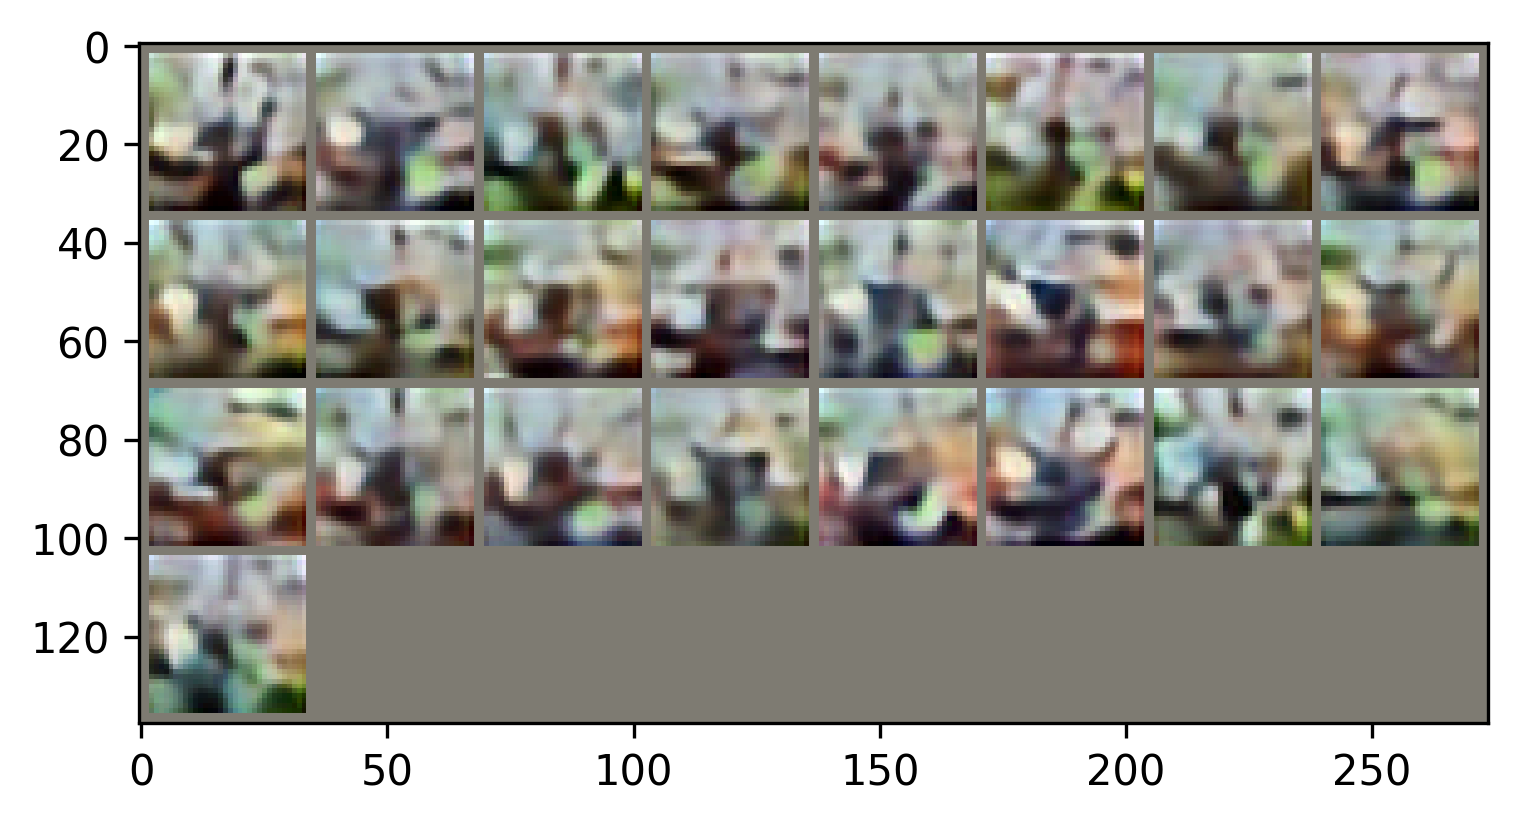

In [30]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

#Z COMES FROM NORMAL(0, 1)
with torch.no_grad():
    embd = vae.encoder(rand_img.to(vae.device))
    mu, log_var, y_hot_em, = vae.fc_mu(embd), vae.fc_var(embd), vae.hot_emb(label)
    std = torch.exp(0.5 * log_var)
    p = torch.distributions.Normal(mu, std)
    z = p.rsample((25,)).squeeze()

    print(z.shape, y_hot_em.shape)

    z = z + y_hot_em
    z = vae.mix(z)


# SAMPLE IMAGES
with torch.no_grad():

  pred = vae.decoder(z.to(vae.device))

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array([0.4942,0.4851,0.4504]), np.array([0.2467,0.2429,0.2616])

img = make_grid(pred).permute(1, 2, 0).numpy()* std + mean
img_rand = make_grid(rand_img).permute(1, 2, 0).numpy()* std + mean

# PLOT IMAGES
imshow(img);


## Plot images without passing labels to the inferencing pipeline

In [33]:

mean, std = torch.tensor([0.4942,0.4851,0.4504]), torch.tensor([0.2467,0.2429,0.2616])

torch.manual_seed(20)
rand_im = (torch.rand(32,32,3) - mean)/std

rand_im = rand_im.permute(2,0,1).unsqueeze(0)
rand_labl = torch.randint(0,9,(25,))
label = F.one_hot(rand_labl, num_classes=10).float()
print(rand_labl)

vae = VAE.load_from_checkpoint("vae_cifar.ckpt")

vae.device


tensor([6, 8, 7, 0, 0, 7, 6, 8, 2, 0, 4, 0, 5, 3, 4, 5, 5, 0, 2, 0, 3, 1, 7, 4,
        7])


/tmp/ipykernel_1453735/1055244507.py:20: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/tmp/ipykernel_1453735/1055244507.py:21: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(


device(type='cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 256]) torch.Size([25, 256])


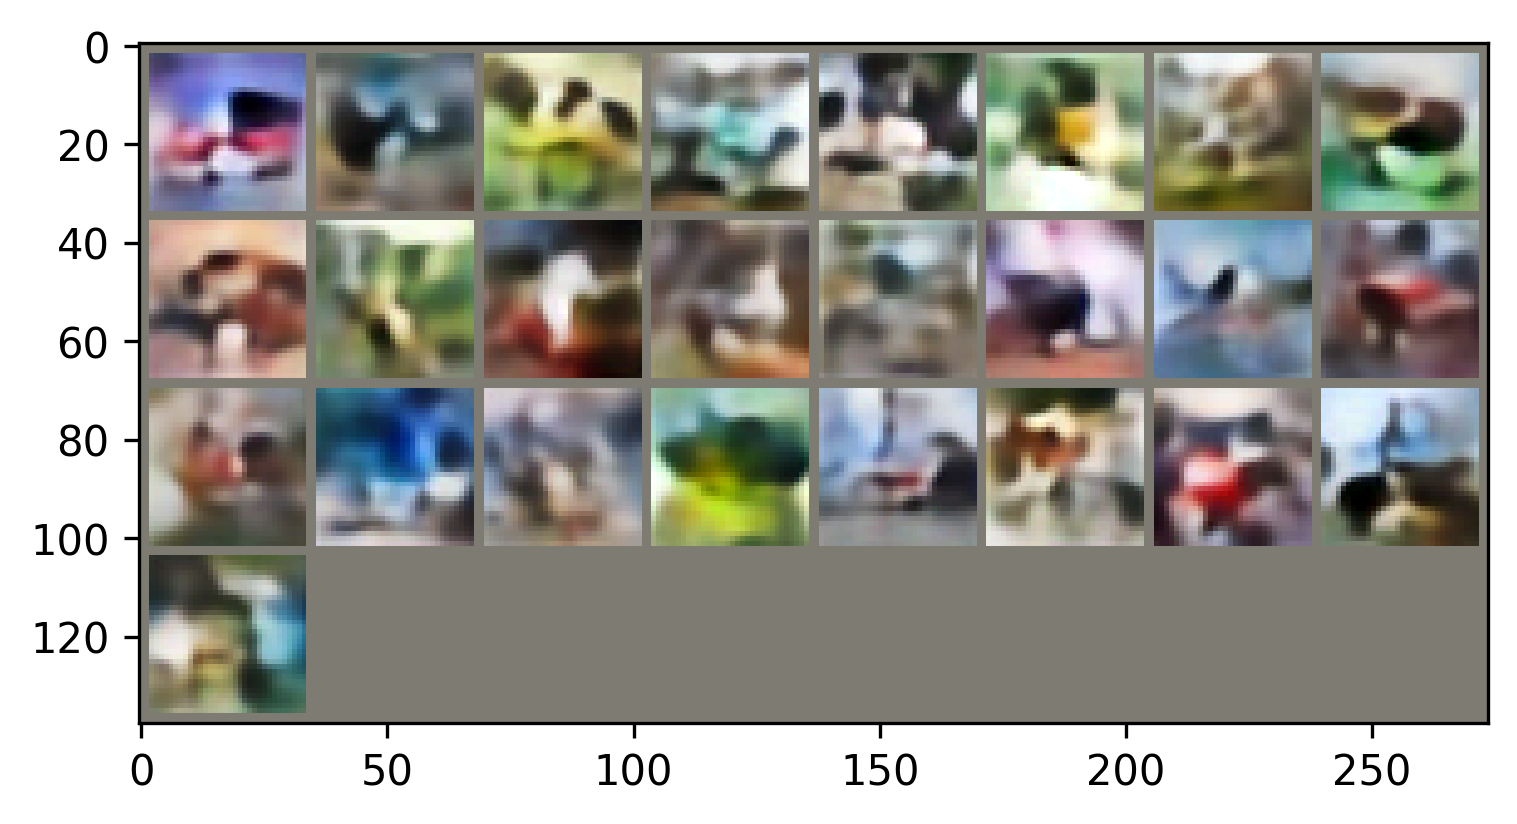

In [34]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

#Z COMES FROM NORMAL(0, 1)
with torch.no_grad():
    embd = vae.encoder(rand_im.to(vae.device))
    mu, log_var, y_hot_em, = vae.fc_mu(embd), vae.fc_var(embd), vae.hot_emb(label)
    std = torch.exp(0.5 * log_var)
    p = torch.distributions.Normal(mu, std)
    z = p.rsample((25,)).squeeze()

    print(z.shape, y_hot_em.shape)


# SAMPLE IMAGES
with torch.no_grad():

  pred = vae.decoder(z.to(vae.device))

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array([0.4942,0.4851,0.4504]), np.array([0.2467,0.2429,0.2616])

img = make_grid(pred).permute(1, 2, 0).numpy()* std + mean
img_rand = make_grid(rand_img).permute(1, 2, 0).numpy()* std + mean

# PLOT IMAGES
imshow(img);
